**water shortage likelihood prediction**

Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif

Load and view aquastat data set

In [2]:
df = pd.read_csv('https://mda-project-poland.s3.eu-west-3.amazonaws.com/ultimate+aquastat+(flat).csv')
df_GDP = pd.read_csv('https://mda-project-poland.s3.eu-west-3.amazonaws.com/GDP.csv')
df.shape
#data = pd.read_csv('https://mda-project-poland.s3.eu-west-3.amazonaws.com/aquastat_data.csv') 
#data = data.pivot_table(index = "Area", columns = "Variable Name", values= "Value")
#data.head()

(5181, 10)

In [3]:
table=pd.pivot_table(data=df,values='Value',index=['Area','Year'],columns='Variable Name') # is used for Time Series Analysis
GDP_table = pd.pivot_table(data=df_GDP,values='Value',index=['Area','Year'],columns='Variable Name')

table = table.merge(GDP_table, how='inner', on=['Area','Year'])
table.head(25)
#location=pd.read_csv('https://mda-project-poland.s3.eu-west-3.amazonaws.com/location.csv',usecols=[ "Area","Latitude","Longitude"])
#location.head()

Variable Name       Agricultural water withdrawal as % of total renewable water resources  \
Area        Year                                                                            
Afghanistan 1992.0                                          35.498101                       
            1997.0                                          31.427856                       
            2002.0                                          30.613807                       
            2007.0                                          30.613807                       
            2012.0                                          30.613807                       
            2017.0                                          30.613807                       
            2018.0                                          30.613807                       
Argentina   1992.0                                                NaN                       
            1997.0                                           2.455948                       
            2002.0                                           2.588954                       
            2007.0                                           2.921470                       
            2012.0                                           3.187483                       
            2017.0                                           3.187483                       
            2018.0                                           3.187483                       
Australia   1992.0                                                NaN                       
            1997.0                                           3.131301                       
            2002.0                                           2.913110                       
            2007.0                                           1.987195                       
            2012.0                                           1.948577                       
            2017.0                                           2.250000                       
            2018.0                                           2.444073                       
Azerbaijan  1992.0                                          31.521269                       
            1997.0                                          26.687815                       
            2002.0                                          18.387888                       
            2007.0                                          24.746936                       

Variable Name       Agriculture, value added (% GDP)  Average Temperature  \
Area        Year                                                            
Afghanistan 1992.0                         54.207106                12.61   
            1997.0                         62.416768                12.86   
            2002.0                         45.134344                13.91   
            2007.0                         35.265942                13.80   
            2012.0                         28.556142                13.25   
            2017.0                         25.574670                13.12   
            2018.0                         22.440899                14.55   
Argentina   1992.0                          5.193747                14.37   
            1997.0                          4.527197                15.14   
            2002.0                          8.848660                14.60   
            2007.0                          7.452354                14.20   
            2012.0                          5.781744                15.20   
            2017.0                          5.478382                15.30   
            2018.0                          6.097129                14.99   
Australia   1992.0                          3.263718                21.75   
            1997.0                          3.038954                21.82   
            2002.0                          2.888534                22.25   
            2007.0       

In [4]:
table_preprocessed = table.groupby('Area').apply(lambda group: group.interpolate(method='linear',axis=1))
table_preprocessed = table_preprocessed.fillna(method='bfill')
table_preprocessed.head(49)
#data =location.merge(data, on="Area", how="left")
#data

Variable Name                            Agricultural water withdrawal as % of total renewable water resources  \
Area                             Year                                                                            
Afghanistan                      1992.0                                          35.498101                       
                                 1997.0                                          31.427856                       
                                 2002.0                                          30.613807                       
                                 2007.0                                          30.613807                       
                                 2012.0                                          30.613807                       
                                 2017.0                                          30.613807                       
                                 2018.0                                          30.613807                       
Argentina                        1992.0                                           2.455948                       
                                 1997.0                                           2.455948                       
                                 2002.0                                           2.588954                       
                                 2007.0                                           2.921470                       
                                 2012.0                                           3.187483                       
                                 2017.0                                           3.187483                       
                                 2018.0                                           3.187483                       
Australia                        1992.0                                           3.131301                       
                                 1997.0                                           3.131301                       
                                 2002.0                                           2.913110                       
                                 2007.0                                           1.987195                       
                                 2012.0                                           1.948577                       
                                 2017.0                                           2.250000                       
                                 2018.0                                           2.444073                       
Azerbaijan                       1992.0                                          31.521269                       
                                 1997.0                                          26.687815                       
                                 2002.0                                          18.387888                       
                                 2007.0                                          24.746936                       
                                 2012.0                                          25.629416                       
                                 2017.0                                          32.187455                       
                                 2018.0                                          32.406633                       
Bolivia (Plurinational State of) 1992.0                                           0.236106                       
                                 1997.0                                           0.288589                       
                                 2002.0                                           0.317886                       
                                 2007.0                                           0.331727                       
                                 2012.0                                           0.334495                       
          

Calculate the new variables, divide the water shortage indicator into 4 risk levels

In [14]:
data=table_preprocessed.copy()
#data['% of total country area irrigated (%)']=data['% of total country area cultivated']*data['% of cultivated land irrigated [harvested crop]']/100
data['Industry, value added (% GDP)']=data['Industry, value added to GDP']/data['Gross Domestic Product (GDP)']*100
data['Services, value added (% GDP)']=data['Services, value added to GDP']/data['Gross Domestic Product (GDP)']*100
data['water resource per capita']=data['Total renewable water resources per capita']-data['Environmental Flow Requirements']
data['shortageclass'] = pd.cut(data['water resource per capita'],bins=[0,500,1000,1700,240000],labels=['3','2','1','0'])

In [15]:
data.head()

Variable Name       Agricultural water withdrawal as % of total renewable water resources  \
Area        Year                                                                            
Afghanistan 1992.0                                          35.498101                       
            1997.0                                          31.427856                       
            2002.0                                          30.613807                       
            2007.0                                          30.613807                       
            2012.0                                          30.613807                       

Variable Name       Agriculture, value added (% GDP)  Average Temperature  \
Area        Year                                                            
Afghanistan 1992.0                         54.207106                12.61   
            1997.0                         62.416768                12.86   
            2002.0                         45.134344                13.91   
            2007.0                         35.265942                13.80   
            2012.0                         28.556142                13.25   

Variable Name       Environmental Flow Requirements  GDP per capita  \
Area        Year                                                      
Afghanistan 1992.0                            28.29      248.518890   
            1997.0                            28.29      164.092893   
            2002.0                            28.29      194.958382   
            2007.0                            28.29      389.985586   
            2012.0                            28.29      694.885618   

Variable Name       Industry, value added to GDP  \
Area        Year                                   
Afghanistan 1992.0                  5.530000e+08   
            1997.0                  4.220000e+08   
            2002.0                  9.150000e+08   
            2007.0                  2.600000e+09   
            2012.0                  4.360000e+09   

Variable Name       Long-term average annual precipitation in volume  \
Area        Year                                                       
Afghanistan 1992.0                                         213.48522   
            1997.0                                         213.48522   
            2002.0                                         213.48522   
            2007.0                                         213.48522   
            2012.0                                         213.48522   

Variable Name       MDG 7.5. Freshwater withdrawal as % of total renewable water resources  \
Area        Year                                                                             
Afghanistan 1992.0                                          35.910480                        
            1997.0                                          31.852952                        
            2002.0                                          31.045461                        
            2007.0                                          31.045461                        
            2012.0                                          31.045461                        

Variable Name       National Rainfall Index (NRI)  Population density  ...  \
Area        Year                                                       ...   
Afghanistan 1992.0                         304.98           22.187829  ...   
            1997.0                         233.00           29.649735  ...   
            2002.0                         185.00           34.618096  ...   
            2007.0                         185.00           41.510486  ...   
            2012.0                         185.00           47.730564  ...   

Variable Name       SDG 6.4.2. Water Stress  Services, value added to GDP  \
Area        Year                                                            
Afghanistan 1992.0                63.337788                  9.950000e+08   
   

In [6]:
data.isnull().any()

Variable Name
Agricultural water withdrawal as % of total renewable water resources     False
Agriculture, value added (% GDP)                                          False
Average Temperature                                                       False
Environmental Flow Requirements                                           False
GDP per capita                                                            False
Industry, value added to GDP                                              False
Long-term average annual precipitation in volume                          False
MDG 7.5. Freshwater withdrawal as % of total renewable water resources    False
National Rainfall Index (NRI)                                             False
Population density                                                        False
Prevalence of undernourishment (3-year average)                           False
SDG 6.4.1. Industrial Water Use Efficiency                                False
SDG 6.4.1. Irrigated Agric

## Data Preprocessing and exploration


In [7]:
print(data['water resource per capita'].describe())

count       259.000000
mean      21141.243523
std       40411.946627
min         211.751182
25%        1548.433426
50%        3509.947955
75%       20863.763420
max      235263.846100
Name: water resource per capita, dtype: float64


the distribution of water shortage index

<AxesSubplot:>

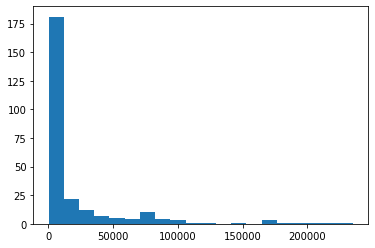

In [8]:
data['water resource per capita'].hist(grid=False, bins=20)

right skewed

dichotomization:

water shortage: water resource per capita<1700 m^3 per person per year

# Classification

In [10]:
X=data.iloc[:,0:23].drop(
    ['Environmental Flow Requirements',
     'Total renewable water resources per capita',
    'Industry, value added to GDP',
    'Services, value added to GDP'],axis=1)
y=data['shortageclass']

## feature selection

In [11]:
pipe = Pipeline([('selector', SelectKBest()),
                 ('classifier', KNeighborsClassifier(leaf_size=5,n_neighbors=15))])
param_grid = [{'selector__k': [ 5, 6, 7, 8, 9, 10]}]

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X, y)

k=grid.best_params_['selector__k']
print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print(grid.best_estimator_)

Best params:
{'selector__k': 7}

Best cross-validation score: 0.70
Pipeline(steps=[('selector', SelectKBest(k=7)),
                ('classifier',
                 KNeighborsClassifier(leaf_size=5, n_neighbors=15))])


## model selection

In [12]:
pipe = Pipeline([('selector', SelectKBest(k=k)),
                 ('classifier', KNeighborsClassifier(leaf_size=5,n_neighbors=15))])
param_grid = [
    {'classifier': [RandomForestClassifier()],
     'classifier__n_estimators':[30, 50, 100],
     'classifier__max_features': [1, 2, 3],
     'classifier__min_samples_leaf':[1, 2, 3]},
    {'classifier': [LogisticRegression(max_iter=7000)]},
    {'classifier': [naive_bayes.GaussianNB()]},
    {'classifier': [KNeighborsClassifier()],
     'classifier__leaf_size': [5,10,15,30],
     'classifier__n_neighbors': [5,10,15]}
    ]

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X, y)

best_pipe=grid.best_estimator_
features = best_pipe.named_steps['selector']

In [13]:
print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best estimator:\n{}\n".format(grid.best_estimator_))
print("Selected features:\n{}\n".format(X.columns[features.get_support()]))

Best params:
{'classifier': RandomForestClassifier(max_features=1, n_estimators=50), 'classifier__max_features': 1, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 50}

Best cross-validation score: 0.83
Best estimator:
Pipeline(steps=[('selector', SelectKBest(k=7)),
                ('classifier',
                 RandomForestClassifier(max_features=1, n_estimators=50))])

Selected features:
Index(['Agricultural water withdrawal as % of total renewable water resources',
       'GDP per capita', 'Long-term average annual precipitation in volume',
       'National Rainfall Index (NRI)', 'Population density',
       'Industry, value added (% GDP)', 'Services, value added (% GDP)'],
      dtype='object', name='Variable Name')

